<a href="https://colab.research.google.com/github/valmirf/redes_neurais_esp/blob/main/RNN/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imagem Captioning

A tarefa de legendagem de imagens [Image Captioning](https://medium.com/analytics-vidhya/use-pytorch-to-create-an-image-captioning-model-with-cnn-and-seq2seq-lstm-and-train-on-google-e6563cb9f511) é uma das atividades que se tornaram mais impressionantes ultimamente. Essa atividade descreve objetos dentro de uma imagem. A partir de uma base de imagens com anotações, o algoritmo é capaz de descrever outras imagens. Para esta atividade, iremos utilizar a Base de Imagens COCO da Microsoft, pois ela contém as anotações necessárias pra treinar um algoritmo. 

Geralmente, um modelo de legendagem é uma combinação de duas arquiteturas separadas que são CNN (Redes Neurais Convolucionais) e RNN (Redes Neurais Recorrentes). Basicamente, o CNN é usado para gerar vetores de características a partir dos dados espaciais nas imagens e os vetores são alimentados através da camada linear totalmente conectada na arquitetura RNN, a fim de gerar os dados sequenciais ou sequência de palavras que no final geram a descrição de um imagem.

##Base de Dados COCO
O conjunto de dados COCO é um dos maiores conjuntos de dados de imagens publicamente disponíveis e destina-se a representar cenas realistas. Essas imagens vêm em uma variedade de formas com uma variedade de objetos e condições de ambientes e de iluminação que representam de perto o que você poderia obter se compilasse imagens de muitas câmeras diferentes em todo o mundo.

Para explorar o conjunto de dados, você pode verificar o [site](https://cocodataset.org/#explore) da base de dados

Cada imagem vem com 5 legendas diferentes produzidas por pessoas diferentes, portanto, cada legenda é um pouco (as vezes muito) diferente das outras legendas da mesma imagem. Aqui está um exemplo de um ponto de dados do conjunto de dados COCO.

![](https://raw.githubusercontent.com/valmirf/redes_neurais_esp/main/RNN/FIG/coco.png)



## Download a Base de Dados: Anotações, legendas, imagens

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

In [ ]:
import os 
import sys
from pycocotools.coco import COCO
import urllib
import zipfile 

In [ ]:
os.makedirs('opt' , exist_ok=True)
os.chdir( '/content/opt' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

In [ ]:
os.chdir('/content/opt/cocoapi')

# Download the annotation : 
annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

urllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )
urllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )

Extrai as anotações do arquivo ZIP

In [ ]:
with zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'annotations_trainval2014.zip' )
  print('zip removed')
except:
  None

with zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'image_info_test2014.zip' )
  print('zip removed')
except:
  None

Inicializar e verificar os dados carregados

In [ ]:
os.chdir('/content/opt/cocoapi/annotations')
# initialize COCO API for instance annotations
dataType = 'val2014'
instances_annFile = 'instances_{}.json'.format(dataType)
print(instances_annFile)
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = 'captions_{}.json'.format(dataType)
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

Apresenta um exemplo de Imagem e Legendas

In [ ]:
import matplotlib.pyplot as plt 
import skimage.io as io 
import numpy as np 
%matplotlib inline 

In [ ]:
#Pick a random annotation id and display img of that annotation  :
ann_id = np.random.choice( ids )
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs( img_id )[0]
url = img['coco_url']
print(url)
I = io.imread(url)
plt.imshow(I)

# Display captions for that annotation id :
ann_ids = coco_caps.getAnnIds( img_id   )
print('Number of annotations i.e captions for the image: ' , ann_ids)
print()
anns = coco_caps.loadAnns( ann_ids )
coco_caps.showAnns(anns)

Baixa as bases de dados de Treinamento, Validação e Teste:

In [ ]:
os.chdir('/content/opt/cocoapi')

train2014 = 'http://images.cocodataset.org/zips/train2014.zip'
test2014 = 'http://images.cocodataset.org/zips/test2014.zip'
#val2014 = 'http://images.cocodataset.org/zips/val2014.zip'

urllib.request.urlretrieve( train2014 , 'train2014' )
urllib.request.urlretrieve( test2014 , 'test2014' )
#urllib.request.urlretrieve( val2014 , 'val2014' )


Descompacta as imagens baixadas

In [ ]:
os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'train2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'train2014' )
  print('zip removed')
except:
  None


os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'test2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'test2014' )
  print('zip removed')
except:
  None

zip removed
zip removed


## Passo 1: Manipulando a Base de Dados

Nesta etapa, cria uma classe chamada Vocabulary pra manipular o texto contido nas imagens. 


No método __call__, a variável `word2idx` é um dicionário Python indexado por chaves string-valor (principalmente tokens obtidos das legendas de treinamento). Para cada chave, o valor correspondente é o número inteiro para o qual o token é mapeado na etapa de pré-processamento.

O dicionário `word2idx` é criado repetindo as legendas no conjunto de dados de treinamento. Se um token aparecer não menos que o valor de `vocab_threshold` vezes no conjunto de treinamento, ele será adicionado como uma chave ao dicionário e atribuído a um número inteiro exclusivo correspondente. Observe que, em geral, valores menores para `vocab_threshold` geram um número maior de tokens no vocabulário. 


O valor `vocab_from_file` é utilizado para carregar um vocabulário de um arquivo. Observe que ao criar um novo carregador de dados, o vocabulário (`data_loader.dataset.vocab`) é salvo como um arquivo pickle na pasta do projeto, com o nome de arquivo `vocab.pkl`.

Se você ainda está criando ou ajustanto um vocabulário, o valor do argumento deve ser `vocab_from_file=False`. Quando estiver satisfeito com o valor que escolheu para o argumento `vocab_threshold`, você só precisa executar o carregador de dados mais uma vez com o `vocab_threshold` escolhido para salvar o novo vocabulário no arquivo. Então, você pode definir 'vocab_from_file = True' para carregar o vocabulário do arquivo e acelerar a instanciação do _DataLoader_. 




In [ ]:
# vocabulary.py -------------------------------------------------------------
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2014.json',
        vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

### Cria o iterator
A função `get_loader` recebe como entrada uma série de argumentos que podem ser explorados:

1. `transform` - uma transformação de imagem que especifica como pré-processar as imagens e convertê-las em tensores PyTorch antes de usá-las como entrada para o codificador CNN. Por enquanto, você é encorajado a manter a transformação conforme fornecida em transform_train. 
2. `mode` - um de 'treinar' (carrega os dados de treinamento em lotes) ou 'teste' (para os dados de teste). Diremos que o carregador de dados está em modo de treinamento ou teste, respectivamente. Ao seguir as instruções neste notebook, mantenha o carregador de dados no modo de treinamento configurando mode = 'train'.
2. `batch_size` - determina o tamanho do lote. Ao treinar o modelo, este é o número de pares de imagem-legenda usados ​​para corrigir os pesos do modelo em cada etapa de treinamento.
3. `vocab_threshold` - o número total de vezes que uma palavra deve aparecer nas legendas de treinamento antes de ser usada como parte do vocabulário. Palavras com menos ocorrências de `vocab_threshold` nas legendas de treinamento são consideradas palavras desconhecidas.
4. `vocab_from_file` - um Booleano que decide se deve carregar o vocabulário pré-existente.




O método __getitem__ na classe CoCoDataset determina como um par de imagem-legenda é pré-processado antes de ser incorporado a um _batch_. 

Quando o _DataLoader_ está no modo de treinamento, este método começa primeiro obtendo o nome do arquivo (caminho) de uma imagem de treinamento e sua legenda (legenda) correspondente.

Depois de carregar a imagem na pasta de treinamento com o caminho do nome, a imagem é pré-processada usando a mesma transformação (`transform_train`) que foi fornecida ao instanciar o carregador de dados.

In [ ]:
# Data Loader ---------------------------------------------------------------------------------------------

import nltk
import os
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json

def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    """
    
    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/test2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':            
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

### Cria o DataLoader
Cria o DataLoader que o PyTorch utiliza para iterar os dados nas etapas de treinamento e teste. Note que na etapa de treinamento vamos retornar o par (imagem, anotação). 

A entrada do codificador CNN pré-treinado aceita uma imagem de tamanho (224 x 224 x 3), portanto, este é o tamanho final da imagem que pretendemos. Antes de fazer isso, aumentamos nossos dados de treinamento cortando aleatoriamente uma área da imagem depois de redimensionar a imagem para 256. Também usamos uma inversão horizontal para aumentar nossos dados com uma probabilidade de 0,5 e, em seguida, converte-se a imagem em um Tensor. Por fim, normalizamos a imagem pelos valores usados ​​para o conjunto de dados ImageNet.


In [ ]:
import sys
from pycocotools.coco import COCO
!pip install nltk
import nltk
nltk.download('punkt')
from torchvision import transforms


# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 8

# Specify the batch size.
batch_size = 64

# Obtain the data loader.
data_loader_train = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         cocoapi_loc = '/content/opt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
loading annotations into memory...
Done (t=2.38s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.57s)
creating index...


  0%|          | 1034/414113 [00:00<00:40, 10326.64it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:41<00:00, 9877.71it/s] 


## Pré-processamento do texto
Pré-processamento de legenda

As legendas também precisam ser pré-processadas e preparadas para o treinamento. Neste exemplo, para gerar legendas, pretendemos criar um modelo que preveja o próximo token de uma frase de tokens anteriores, então transformamos a legenda associada a qualquer imagem em uma lista de palavras tokenizadas, antes de lançá-la em um tensor PyTorch que podemos usar para treinar a rede. Cada palavra é associada a um identificador criado a partir da base de dados de treinamento. Portanto, cada palavra da legenda terá um valor inteiro correspondente que pode ser encontrado num dicionário. As palavras neste dicionário são chamadas de vocabulário.


As palavras especiais (`<start>`) e (`<end>`) são decididas ao instanciar o _DataLoader_ e são passadas como um parâmetro. Se o padrão for mantido, o inteiro 0 é sempre usado para marcar o início de uma legenda e o inteiro 1 para marcar o fim da legenda.

In [ ]:
import torch 
import numpy as np 
import torch.utils.data as data

# Exploring the dataloader now :
sample_caption = 'A person doing a trick on a rail while riding a skateboard.'
sample_tokens = nltk.tokenize.word_tokenize( sample_caption.lower() )

#Cria um vocabulário a partir das frases da base de treinamento
sample_caption = []
start_word  = data_loader_train.dataset.vocab.start_word
end_word = data_loader_train.dataset.vocab.end_word
sample_tokens.insert(0 , start_word)
sample_tokens.append(end_word)
sample_caption.extend( [ data_loader_train.dataset.vocab(token) for token in sample_tokens ] )


sample_caption = torch.Tensor( sample_caption ).long()
print('Find Below the Sample tokens and the idx values of those tokens in word2idx' , '\n')
print(sample_tokens) 
print(sample_caption )

print('Find index values for words below \n')
print('Start idx {} , End idx {} , unknown idx {}'.format( 0,1,2 ))

Find Below the Sample tokens and the idx values of those tokens in word2idx 

['<start>', 'a', 'person', 'doing', 'a', 'trick', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.', '<end>']
tensor([  0,   3,  97, 744,   3, 393,  38,   3, 992, 205, 137,   3, 743,  18,
          1])
Find index values for words below 

Start idx 0 , End idx 1 , unknown idx 2


In [ ]:
# Lets check word2idx in vocb 
print('First few vocab' , dict(list(data_loader_train.dataset.vocab.word2idx.items())[:10]))
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader_train.dataset.vocab))

First few vocab {'<start>': 0, '<end>': 1, '<unk>': 2, 'a': 3, 'very': 4, 'clean': 5, 'and': 6, 'well': 7, 'decorated': 8, 'empty': 9}
Total number of tokens in vocabulary: 7073


## Passo 2: Use o DataLoader para obter lotes
As legendas no conjunto de dados variam muito em comprimento. É possível verificar isso examinando `data_loader.dataset.caption_lengths`, uma lista Python com uma entrada para cada legenda de treinamento (onde o valor armazena o comprimento da legenda correspondente).

Na célula de código abaixo, usamos essa lista para imprimir o número total de legendas nos dados de treinamento com cada comprimento. Como você verá abaixo, a maioria das legendas tem tamanho 10. Da mesma forma, legendas muito curtas e muito longas são muito raras. 

In [ ]:
from collections import Counter

counter = Counter(data_loader_train.dataset.caption_lengths)
lengths = sorted( counter.items() , key = lambda pair : pair[1] , reverse=True )
for val,count in lengths:
  print( 'value %2d  count %5d' %(val,count) )
  if count < 10000: 
    break

value 10  count 86334
value 11  count 79948
value  9  count 71934
value 12  count 57637
value 13  count 37645
value 14  count 22335
value  8  count 20771
value 15  count 12841
value 16  count  7729


Para gerar lotes de dados de treinamento, vamos utilizar uma técnica descrita no [artigo](https://arxiv.org/pdf/1502.03044.pdf). Selecionamos um comprimento de legenda aleatoriamente (onde a probabilidade de que qualquer comprimento selecionado é proporcional ao número de legendas com aquele comprimento no conjunto de dados). Em seguida, recuperamos um lote de tamanho batch_size de pares imagem-legenda, onde todas as legendas têm o comprimento selecionado. 

Execute a célula de código abaixo para gerar um lote. O método `get_train_indices` na classe `CoCoDataset` primeiro faz a seleção de um comprimento de legenda e, em seguida, mostra os índices `batch_size` correspondentes com legendas desse comprimento. Esses índices são armazenados em `indices`.

Esses índices são fornecidos ao _DataLoader_, que então é usado para recuperar os dados correspondentes. As imagens e legendas pré-processadas no lote são armazenadas em imagens e legendas.

In [ ]:
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader_train.dataset.get_train_indices()
print('Sample Indices:' , indices )

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
sampler = data.sampler.SubsetRandomSampler(  indices )
data_loader_train.batch_sampler.sampler = sampler 

# obtain images, caption :
images , captions = next(iter(data_loader_train))
print(images.shape , captions.shape)

Sample Indices: [185306, 352142, 255219, 99846, 410483, 92934, 169078, 273237, 119757, 24818, 177026, 207283, 325859, 41749, 218158, 119648, 52870, 172824, 95747, 274297, 200739, 22592, 339383, 7409, 359837, 248997, 230074, 101096, 330537, 112454, 239678, 144839, 242310, 270572, 162657, 246300, 343864, 306217, 336157, 254613, 132162, 412278, 220935, 123852, 179230, 170355, 343936, 46437, 339972, 10995, 308687, 307876, 208391, 6716, 93015, 224954, 234893, 166681, 326049, 252323, 31373, 36788, 230602, 319451]
torch.Size([64, 3, 224, 224]) torch.Size([64, 12])



## Passo 3: Codificador CNN (_Encoder_)

O codificador usa a arquitetura ResNet-50 pré-treinada (com a camada final totalmente conectada removida), para extrair características de um lote de imagens pré-processadas. A saída é então achatada em um vetor, antes de ser passada por uma camada `Linear` para transformar o vetor de características para o mesmo tamanho da palavra _embedding_.

![](https://raw.githubusercontent.com/valmirf/redes_neurais_esp/main/RNN/FIG/encoder.png)



In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)        
        features = features.view(features.size(0), -1)        
        features = self.embed(features)        
        return features
    

In [ ]:
# specify dim of image embedding
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_size = 100 
encoder = EncoderCNN( embed_size )
encoder.to(device)
images =  images.to(device) # images from step2 
features = encoder(images)

print(type(features) , features.shape , images.shape)
assert( type(features) == torch.Tensor )  , 'Encoder output should be pytorch tensor'
assert (features.shape[0] == batch_size) & (features.shape[1] == embed_size) , "The shape of the encoder output is incorrect."

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



<class 'torch.Tensor'> torch.Size([64, 100]) torch.Size([64, 3, 224, 224])


## Step 4: Decodificador RNN (_Decoder_)
O Decodificador é uma Rede Neural Recorrente. Abaixo, vamos usar uma Rede Neural LSTM. A LSTM será responsável por aprender a associar legendas com as características das imagens extraídas das imagens na etapa anterior. No código abaixo, `outputs` deve ser um tensor PyTorch com tamanho` [batch_size, captions.shape[1], vocab_size]`. Sua saída deve ser projetada de forma que `outputs[i, j, k]` contenha a previsão do modelo, indicando a probabilidade de o `j`-ésimo token da ` i`-ésima legenda no lote, ser o `k`-ésimo token no vocabulário. 


![](https://raw.githubusercontent.com/valmirf/redes_neurais_esp/main/RNN/FIG/decoder.png)

A função `Predict` é usada para imprimir a legenda prevista do modelo para o vetor de características de uma imagem passada no argumento.


In [ ]:
import os 
import torch.utils.data as data 
import torch 
import math
import pickle
import matplotlib.pyplot as plt 
% matplotlib inline

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super( DecoderRNN , self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.word_embedding = nn.Embedding( self.vocab_size , self.embed_size )
        self.lstm  = nn.LSTM(    input_size  =  self.embed_size , 
                             hidden_size = self.hidden_size,
                             num_layers  = self.num_layers ,
                             batch_first = True 
                             )
        self.fc = nn.Linear( self.hidden_size , self.vocab_size  )
        

    def init_hidden( self, batch_size ):
      return ( torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device),
      torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device) )
    
    def forward(self, features, captions):            
      captions = captions[:,:-1]      
      self.batch_size = features.shape[0]
      self.hidden = self.init_hidden( self.batch_size )
      embeds = self.word_embedding( captions )
      inputs = torch.cat( ( features.unsqueeze(dim=1) , embeds ) , dim =1  )      
      lstm_out , self.hidden = self.lstm(inputs , self.hidden)      
      outputs = self.fc( lstm_out )      
      return outputs


    def predict(self, inputs, max_len=20):        
        final_output = []    
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)            
        hidden = self.init_hidden(batch_size) # Get initial hidden state of the LSTM
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) # lstm_out shape : (1, 1, hidden_size) 
            outputs = self.fc(lstm_out)  # outputs shape : (1, vocab_size)
            outputs = outputs.squeeze(1) 
            _, max_idx = torch.max(outputs, dim=1) # predict the most likely next word, max_indice shape : (1)            
            final_output.append(max_idx.cpu().numpy()[0].item()) # storing the word predicted                        
            if (max_idx == 1):
                # We predicted the <end> word, so there is no further prediction to do
                break            
            ## Prepare to embed the last predicted word to be the new input of the lstm
            inputs = self.word_embedding(max_idx) # inputs shape : (1, embed_size)
            inputs = inputs.unsqueeze(1)    # inputs shape : (1, 1, embed_size)                     
        return final_output  

### Execução do Encoder e Decoder

Temos dois componentes do modelo, o codificador e decodificador. Eles são treinados em conjunto, passando a saída do codificador, que é a rede neural convolucional, para o decodificador, que, por sua vez, é a rede neural recorrente conforme visto na figura abaixo. 


![](https://github.com/valmirf/redes_neurais_esp/blob/main/RNN/FIG/encoder-decoder.png?raw=true)

Nesta etapa do notebook, você poderá personalizar o treinamento do modelo CNN-RNN, especificando hiperparâmetros e configurando outras opções importantes para o procedimento de treinamento. 


In [ ]:
hidden_size = 512
num_layers = 1 
num_epochs = 1
print_every = 200
save_every = 10 
vocab_size = len(data_loader_train.dataset.vocab)
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Número total de passos de treinamento por época.
total_step = math.ceil( len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size   )


decoder = DecoderRNN(  embed_size , hidden_size, vocab_size ,num_layers)
criterion = nn.CrossEntropyLoss()
lr = 0.001
#Especifica quais parâmetros da rede serão aprendidos
all_params = list(decoder.parameters())  + list( encoder.embed.parameters() )
optimizer = torch.optim.Adam( params  = all_params , lr = lr  )


model_save_path = '/content/opt/cocoapi/RNN_LSTM/image_caption/CVND---Image-Captioning-Project/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

# Save the params needed to created the model :
decoder_input_params = {'embed_size' : embed_size , 
                'hidden_size' : hidden_size , 
                'num_layers' : num_layers,
                'lr' : lr ,
                'vocab_size' : vocab_size
                }

with open( os.path.join(model_save_path , 'decoder_input_params_27_11_2020.pickle'), 'wb') as handle:
    pickle.dump(decoder_input_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import sys 
for e in range(num_epochs):
  for step in range(total_step):
    indices = data_loader_train.dataset.get_train_indices()
    new_sampler = data.sampler.SubsetRandomSampler( indices )
    data_loader_train.batch_sampler.sampler = new_sampler    
    images,captions = next(iter(data_loader_train))    
    images , captions = images.to(device) , captions.to(device)
    encoder , decoder = encoder.to(device) , decoder.to(device)
    encoder.zero_grad()    
    decoder.zero_grad()
    features = encoder(images)
    output = decoder( features , captions )    
    loss = criterion( output.view(-1, vocab_size) , captions.view(-1) )
    loss.backward()
    optimizer.step()
    stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] ' %( e+1,num_epochs,step,total_step,loss.item() )
    if step % print_every == 0 :
      print(stat_vals)
      sys.stdout.flush()
    if e % save_every == 0:
      torch.save( encoder.state_dict() ,  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(e+1) ) )
      torch.save( decoder.state_dict() ,  os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(e+1) ) )


Epochs [1/1] Step [0/200] Loss [8.8595] 


Carrega o arquivo da rede salvo (_checkpoint_):

In [ ]:
model_save_path = '/content/opt/cocoapi/RNN_LSTM/image_caption/CVND---Image-Captioning-Project/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(  os.path.join(model_save_path , 'decoder_input_params_27_11_2020.pickle'), 'rb') as handle:
    decoder_input_params = pickle.load(handle)

embed_size = decoder_input_params['embed_size']
hidden_size= decoder_input_params['hidden_size']
vocab_size = decoder_input_params['vocab_size']
num_layers = decoder_input_params['num_layers']

encoder = EncoderCNN( embed_size )
encoder.load_state_dict(   torch.load(  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(1) )   ) )

decoder = DecoderRNN( embed_size , hidden_size , vocab_size , num_layers )
decoder.load_state_dict( torch.load(   os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(1) )   ) )



<All keys matched successfully>

Cria o _Dataloader_ pra base de teste:

In [ ]:
from torchvision import transforms

# Define a transform to pre-process the training images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Obtain the data loader.
data_loader_test = get_loader(transform=transform_test,
                         mode='test',                         
                         cocoapi_loc = '/content/opt')

data_iter = iter(data_loader_test)

Vocabulary successfully loaded from vocab.pkl file!


'a man is a tennis in a field'

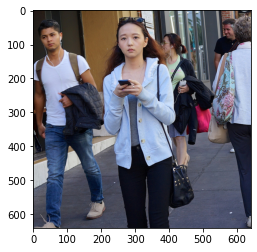

In [ ]:
def get_sentences( original_img, all_predictions ):
  sentence = ' '
  plt.imshow(original_img.squeeze())
  return sentence.join([data_loader_test.dataset.vocab.idx2word[idx] for idx in all_predictions[1:-1] ]  )

encoder.to(device) 
decoder.to(device)
encoder.eval()
decoder.eval()
original_img , processed_img  = next( data_iter )

features  = encoder(processed_img.to(device)   ).unsqueeze(1)
final_output = decoder.predict( features  , max_len=20)
get_sentences(original_img, final_output)